<a href="https://colab.research.google.com/github/frikel12/Machine-Learning-and-Deep-Learningproject/blob/main/Variational_AutoEncoder_VAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Reshape, Conv2D, Conv2DTranspose

In [ ]:
%tensorflow_version 2.x
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Chargement et Pretraitement des données

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print(X_train.shape, '\t', y_train.shape)
print(X_test.shape, '\t', y_test.shape)

(60000, 28, 28) 	 (60000,)
(10000, 28, 28) 	 (10000,)


Les valeurs des pixels dans les données se situent entre 0 et 255. Nous devons donc les normaliser

In [ ]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

Maintenant, nous utilisons la fonction .`reshape()` pour changer le shape de nos données au format
---
attendu par la couche TensorFlow, c'est-à-dire (nombre d'échantillons, largeur, hauteur, nombre de canaux)

In [ ]:
X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))

## Visualization de quelques images


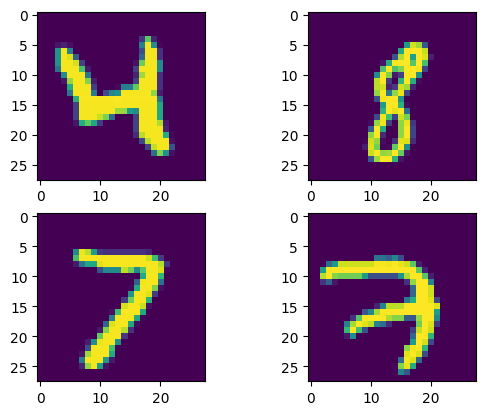

In [ ]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[20][:,:,0])

plt.subplot(222)
plt.imshow(X_train[300][:,:,0])

plt.subplot(223)
plt.imshow(X_train[4000][:,:,0])

plt.subplot(224)
plt.imshow(X_train[5000][:,:,0])
plt.show()

## Architecture du modèle


### Encoder

In [ ]:
enc_input = Input(shape=(28,28,1), name='encoder input')
x = Conv2D(128, 5, padding='same', activation='relu')(enc_input)
x = Conv2D(64, 3, padding='same', strides=2, activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

enc_shape = K.int_shape(x)

In [ ]:
x = Flatten()(x)
x = Dense(32)(x)

#### Latent Space

In [ ]:
latent_dim = 2 #2D space

z_mean = Dense(latent_dim, name='Z-mean')(x)
z_logvar = Dense(latent_dim, name='Z-logvariance')(x)

In [ ]:
def sampling(args):
  mean, logvar = args
  eps = K.random_normal([latent_dim])
  rnd_sam = mean + K.exp(logvar/2) * eps
  return rnd_sam

In [ ]:
z = Lambda(sampling, output_shape=latent_dim, name='latent-space')([z_mean, z_logvar])

In [ ]:
encoder = keras.Model(enc_input, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 128)          3328      ['encoder input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           73792     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']            
                                                                                            

### Decoder
Ici, nous devons prendre le vecteur d'espace latent 2D échantillonné aléatoirement et le reconvertir au format d'origine de l'image, c'est-à-dire 28x28 avec un seul canal.

In [ ]:
dec_input = Input(shape=(latent_dim,), name='decoder-input')

true_shape = enc_shape[1:]

y = Dense(np.prod(true_shape))(dec_input)
y = Reshape(target_shape=true_shape)(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(y)
y = Conv2DTranspose(128, 5, padding='same', activation='relu')(y)
y = Conv2DTranspose(1, 5, padding='same', activation='relu')(y)

In [ ]:
decoder = keras.Model(dec_input, y, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder-input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 12544)             37632     
                                                                 
 reshape_1 (Reshape)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 28, 28, 64)        3692

### Modèle Complet

In [ ]:
enc_output = encoder(enc_input)
dec_output = decoder(enc_output)


vae = keras.Model(enc_input, dec_output, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 552548    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         356545    
                                                                 
Total params: 909093 (3.47 MB)
Trainable params: 909093 (3.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training
custom loss function : la somme de l'erreur de reconstruction et de l'erreur de divergence KL.

In [ ]:
def loss_func(z_mean, z_logvar):

    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 100
        reconstruction_loss = K.mean(K.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(z_mean, z_logvar):
        kl_loss = -0.5 * K.sum(1.0 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=1)
        return kl_loss


    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=opt, loss=loss_func(z_mean, z_logvar))

In [ ]:
history = vae.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/20
  73/1875 [>.............................] - ETA: 24s - loss: 5.8927

KeyboardInterrupt: ignored

## Visualization de test

4
313/313 [==============================] - 2s 4ms/step


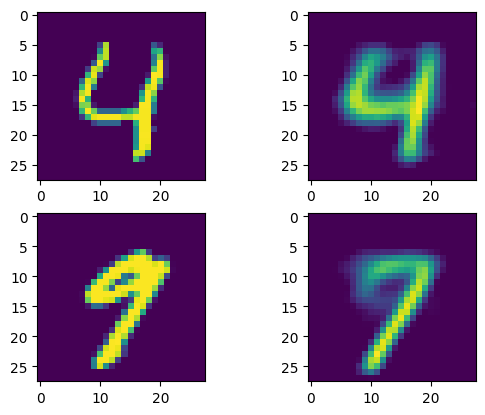

In [ ]:
index = int(input())

y_pred = vae.predict(X_test)

plt.figure(1)
plt.subplot(221)
plt.imshow(X_test[index].reshape(28,28))

plt.subplot(222)
plt.imshow(y_pred[index].reshape(28,28))

plt.subplot(223)
plt.imshow(X_test[index*5].reshape(28,28))

plt.subplot(224)
plt.imshow(y_pred[index*5].reshape(28,28))
plt.show()

Le modèle a réussi à reconstruire la forme générale du vêtement, mais les détails plus fins comme le texte ou les motifs sont perdus. Pour notre cas, c'est satisfaisant

## Enregistrements du modèle

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
keras.models.save_model(encoder, '/content/drive/My Drive/Variational AutoEncoder/mnist/my_model/fm_encoder.keras')
keras.models.save_model(decoder, '/content/drive/My Drive/Variational AutoEncoder/mnist/my_model/fm_decoder.keras')
keras.models.save_model(vae, '/content/drive/My Drive/Variational AutoEncoder/mnist/my_model/fm_vae.keras')

## Exploring our Latent Space
The main application of a VAE is to obtain a low dimensional latent space for our data. Theoritically, every vector in this space is a reduced version of some sample in the original feature space. Exploring the latent space may therefore allow us to find weird, unique and interesting images that may be similar to training samples. The resulting visualization would look cooler with human face datasets, cat image datasets etc, but our plots get the point across.

1/1 [==============================] - 0s 16ms/step


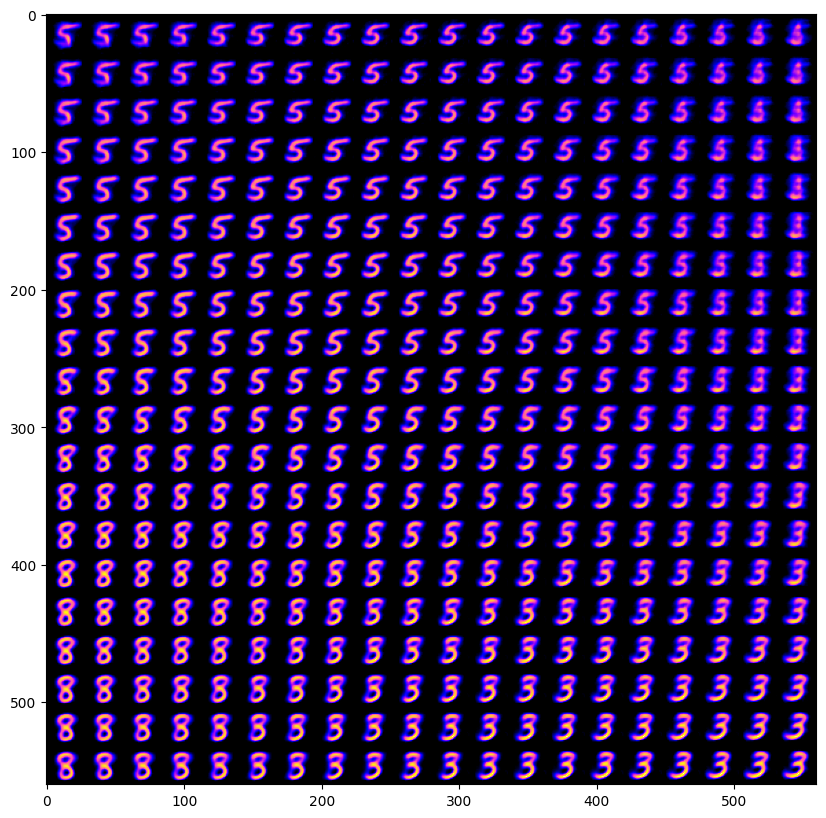

In [ ]:
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #to suppress tensorflow warnings

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

tf.get_logger().setLevel(logging.ERROR)  #to suppress tensorflow warnings

decoder = keras.models.load_model('/content/drive/My Drive/Variational AutoEncoder/mnist/my_model/fm_decoder.keras', compile=False)

#Set the parameters of the plot
n = 20 #20x20 grid
figure = np.zeros((28 * n, 28 * n, 1))
#Set the limits of the area to be explored within our latent space
grid_x = np.linspace(1, 3, n)
grid_y = np.linspace(0, 2, n)[::-1]

#Decode an image for each vector
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded.reshape((28,28,1))
        figure[i*28:(i+1)*28, j*28:(j+1)*28] = digit


#Plotting
plt.figure(figsize=(10, 10))
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))
plt.imshow(figure, cmap='gnuplot2')
plt.show()

1875/1875 [==============================] - 3s 2ms/step


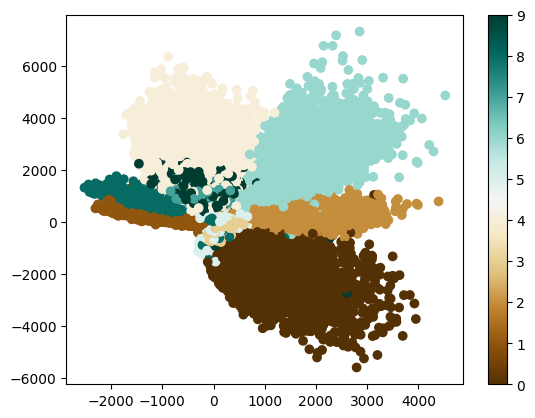

In [ ]:
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #to suppress tensorflow warnings

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

tf.get_logger().setLevel(logging.ERROR)  #to suppress tensorflow warnings

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
#labels = ["Tshirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

latent_dim=2

encoder = keras.models.load_model('/content/drive/My Drive/Variational AutoEncoder/mnist/my_model/fm_encoder.keras', custom_objects={'latent_dim': latent_dim}, safe_mode=False)
z = encoder.predict(X_train)
#print(z)

fig = plt.scatter(z[:,0], z[:,1], c=y_train, cmap='BrBG')
cbar = plt.colorbar(fig)
cbar.set_ticks(list(range(0,10)))
cbar.set_ticklabels(labels)
plt.show()

1/1 [==============================] - 1s 578ms/step


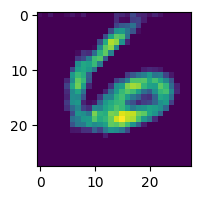

In [ ]:
decoder = keras.models.load_model('/content/drive/My Drive/Variational AutoEncoder/mnist/my_model/fm_decoder.keras', compile=False)

sample_vector = np.array([[2000,3000]])
decoded_example = decoder.predict(sample_vector)
plt.figure(figsize=(2,2))
plt.imshow(decoded_example.reshape(28,28))